In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pint import UnitRegistry
import pandas as pd
ureg = UnitRegistry(autoconvert_offset_to_baseunit=True)
Q_ = ureg.Quantity

In [11]:
data = xr.open_dataset("./temp/test6.nc")
data

<xarray.Dataset> Size: 204kB
Dimensions:     (wavelength: 5100)
Coordinates:
  * wavelength  (wavelength) float64 41kB 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
Data variables:
    Trace 1     (wavelength) float64 41kB ...
    Trace 2     (wavelength) float64 41kB ...
    Trace 3     (wavelength) float64 41kB ...
    Trace 4     (wavelength) float64 41kB ...
Attributes:
    units:         dBm
    date:          2024-09-24 12:36:46
    Group:         Group 3
    start:         1500.0
    stop:          1600.0
    resolution:    0.1
    reference:     0.0
    sensitivity:   Hold
    trace_points:  50
    notes:

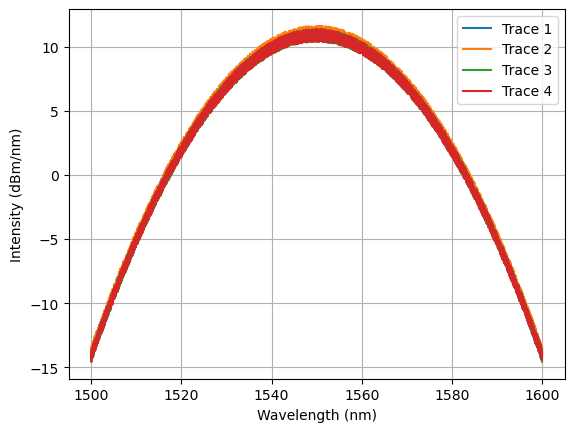

In [13]:
fig, ax = plt.subplots()
if data.attrs['units'] == 'dBm' and data['wavelength'].attrs["units"] == 'nm': #Units sanity check
    for var_name, da in data.data_vars.items():
        # Check if the DataArray is 1D
        if da.ndim == 1:
            res_dB = 10*np.log10(data.attrs['resolution'])
            ax.plot(da['wavelength'],da.values-res_dB, label=var_name)    
    ax.legend()
    ax.set_xlabel(f'Wavelength ({data['wavelength'].attrs["units"]})')
    ax.set_ylabel(f'Intensity ({data.attrs["units"]}/nm)')
    ax.grid()

In [16]:
#Calculate the power between two wavelengths

start_wl = 1520
end_wl = 1550
span = end_wl - start_wl

sub_set = data.sel(wavelength=slice(start_wl, end_wl))


def calc_power(data, constant, resolution):
    linear_data = 10**(data/10)
    sum_linear = linear_data.sum()
    return 10*np.log10(sum_linear * constant / resolution)

result = xr.apply_ufunc(
    calc_power,
    data,
    input_core_dims=[['wavelength']],  # Assuming 'y' is the dimension you want to sum over
    output_core_dims=[[]],
    kwargs={'constant': span/data.wavelength.size,
            'resolution': data.attrs['resolution']},
    vectorize=True
)

result

<xarray.Dataset> Size: 32B
Dimensions:  ()
Data variables:
    Trace 1  float64 8B 21.47
    Trace 2  float64 8B 21.61
    Trace 3  float64 8B 21.34
    Trace 4  float64 8B 21.35

In [35]:
data.wavelength


<xarray.DataArray 'wavelength' (wavelength: 5100)> Size: 41kB
array([1500.      , 1500.019608, 1500.039216, ..., 1599.941176, 1599.960784,
       1599.980392])
Coordinates:
  * wavelength  (wavelength) float64 41kB 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
Attributes:
    units:    nm